In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss

(0) Load

In [2]:
path = '/Users/robertpinochetgomez/GitHub/time-series-analysis/00-data'

df_exports = pd.read_parquet(f'{path}/df_nsc_2025_until_w18.parquet')
df_exports['Week'] = df_exports['Week'].astype('int32')
df_exports.head()

,Country,Volume (KG),Kr/kg,Week,Product,Year,Continent
0,TOTALT,18407,67.23,1,FRESH WHOLE HON,2023,UNCLASSIFIED
1,EU27,13183,64.74,1,FRESH WHOLE HON,2023,EUROPE
2,POLEN,2223,61.44,1,FRESH WHOLE HON,2023,EUROPE
3,FRANKRIKE,2430,66.05,1,FRESH WHOLE HON,2023,EUROPE
4,NEDERLAND,1533,65.60,1,FRESH WHOLE HON,2023,EUROPE


(1) Overall Exports Volume 2023-2024

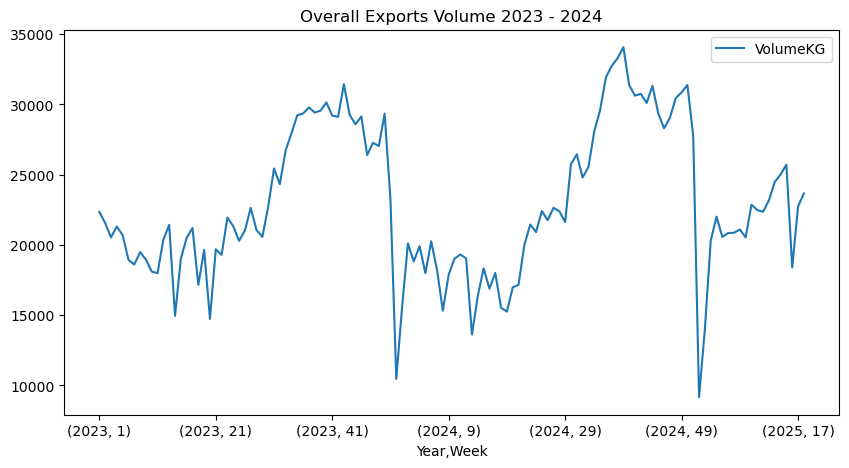

In [3]:
df_totalt = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)
df_totalt.plot(kind='line', figsize=(10,5))
plt.title('Overall Exports Volume 2023 - 2024')
plt.show()

(2) Make it Stationary

- Diff Method: constant mean.

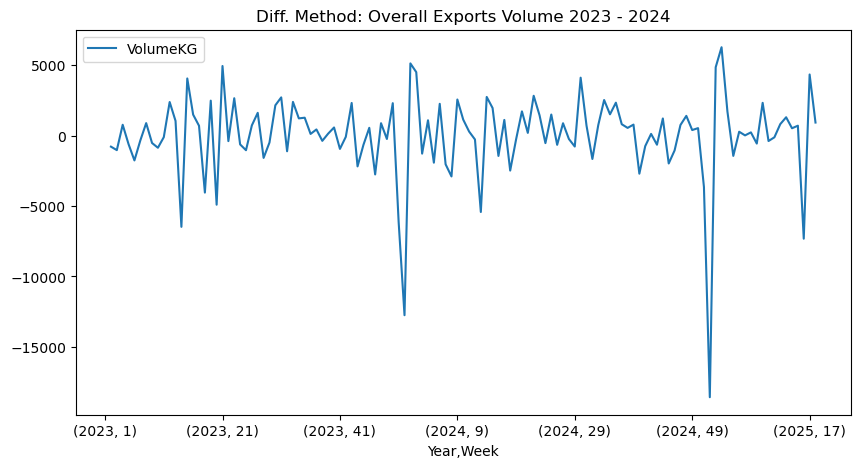

In [4]:
df_totalt = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
).diff()
df_totalt.plot(kind='line', figsize=(10,5))
plt.title('Diff. Method: Overall Exports Volume 2023 - 2024')
plt.show()

Conclusion: Still has a lot of variance. 

- Log Method: stabilise variance. 

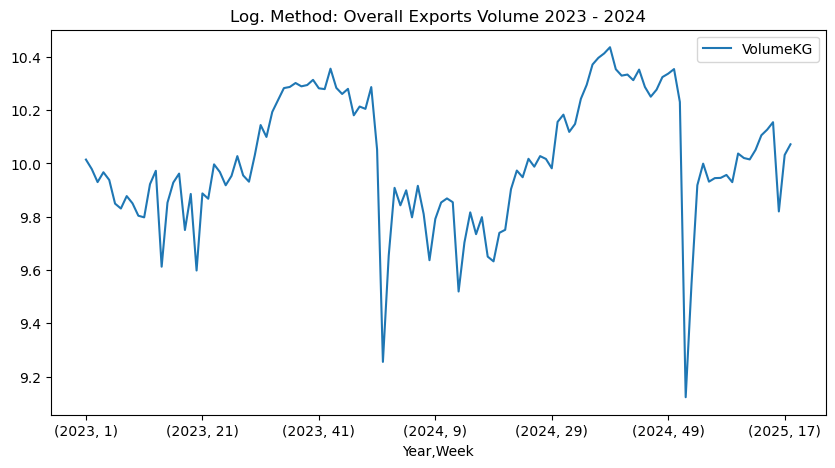

In [5]:
df_totalt = np.log((df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
))
df_totalt.plot(kind='line', figsize=(10,5))
plt.title('Log. Method: Overall Exports Volume 2023 - 2024')
plt.show()

Conclusion: Do not statibilise significantly the variance, due to the model has a more additive nature. 

- Log + Diff

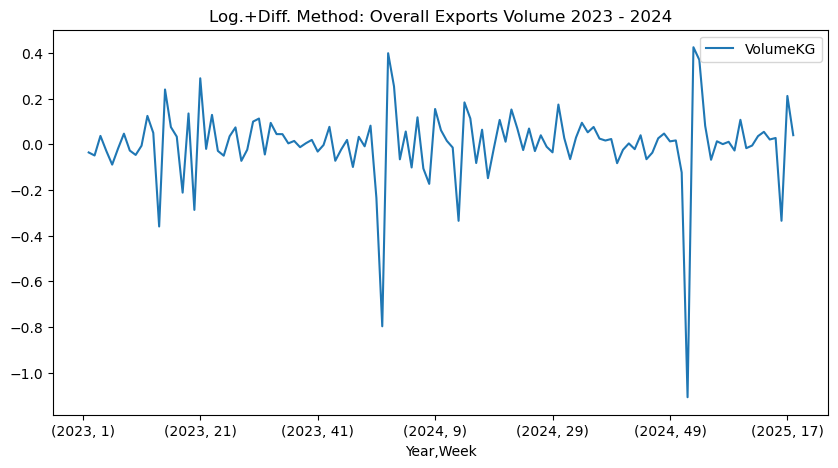

In [6]:
df_totalt = np.log((df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)).diff()
df_totalt.plot(kind='line', figsize=(10,5))
plt.title('Log.+Diff. Method: Overall Exports Volume 2023 - 2024')
plt.show()

Conclusion: A little bit better. 

(3) Apply ADF Test

In [7]:
resultado = adfuller(df_totalt.dropna()) # log + diff method

print(f'Estadístico ADF: {resultado[0]}')
print(f'Valor p: {resultado[1]}')
print('Valores críticos:')
for clave, valor in resultado[4].items():
    print(f'  {clave}: {valor}')
    
# Interpretación básica
if resultado[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie no es estacionaria (no rechazamos H0)")

Estadístico ADF: -9.11920355067617
Valor p: 3.239583087574543e-15
Valores críticos:
  1%: -3.4870216863700767
  5%: -2.8863625166643136
  10%: -2.580009026141913
La serie es estacionaria (rechazamos H0)


In [8]:
volumen_sin_transformar = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)

resultado = adfuller(volumen_sin_transformar) 

print(f'Estadístico ADF: {resultado[0]}')
print(f'Valor p: {resultado[1]}')
print('Valores críticos:')
for clave, valor in resultado[4].items():
    print(f'  {clave}: {valor}')
    
# Interpretación básica
if resultado[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie no es estacionaria (no rechazamos H0)")

Estadístico ADF: -3.2874723864331217
Valor p: 0.015447830877060545
Valores críticos:
  1%: -3.485585145896754
  5%: -2.885738566292665
  10%: -2.5796759080663887
La serie es estacionaria (rechazamos H0)


(4) Apply KS Test

In [9]:
serie_log = df_totalt.dropna()

resultado_kpss = kpss(serie_log, regression='ct')

print(f'Estadístico KPSS: {resultado_kpss[0]}')
print(f'Valor p: {resultado_kpss[1]}')
print('Valores críticos:')
for clave, valor in resultado_kpss[3].items():
    print(f'  {clave}: {valor}')

if resultado_kpss[1] < 0.05:
    print("La serie **no es estacionaria** (rechazamos H0)")
else:
    print("La serie **es estacionaria** (no rechazamos H0)")

Estadístico KPSS: 0.06162170679027202
Valor p: 0.1
Valores críticos:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216
La serie **es estacionaria** (no rechazamos H0)


/var/folders/gd/zbkv9p116_d7x9h_skjnp3tm0000gn/T/ipykernel_22752/3174126500.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado_kpss = kpss(serie_log, regression='ct')


La verdad es que no estoy muy convencido por lo que veo gráficamenente al aplicar las simples transformaciones de log y diff para dejar estacionaria la serie de tiempo. Cabe destacar que las exportaciones de noruega en el tiempo se mantiene con un naturaleza aditiva, es decir, no va incrementando en el tiempo, pero que posee dos estacionalidades claras, una durante el primer trimestre, y la segunda hasta fin de año... que es cuando comienza a incrementar. 
Sin embargo, los estadísticos, con un alto nivel de significancia aprueban que la serie de tiempo es estacionaria. 
Pero al parecer es solo un sesgo mío, ya que no estoy convencido por los outliers (altas) bajas que posee la serie de tiempo al dejarla estacionaria. Sin embargo, eso justo calza con el fin de la cosecha anual. 

## Bonus

Box Cox Transformation (for ARIMA purposes)

In [10]:
import plotly.express as px
from scipy.stats import boxcox

In [11]:
df_box_cox = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)

In [12]:
# Apply box-cox transform and plot it
df_box_cox['Volume_box_cox'], lam = boxcox(df_box_cox['VolumeKG'])

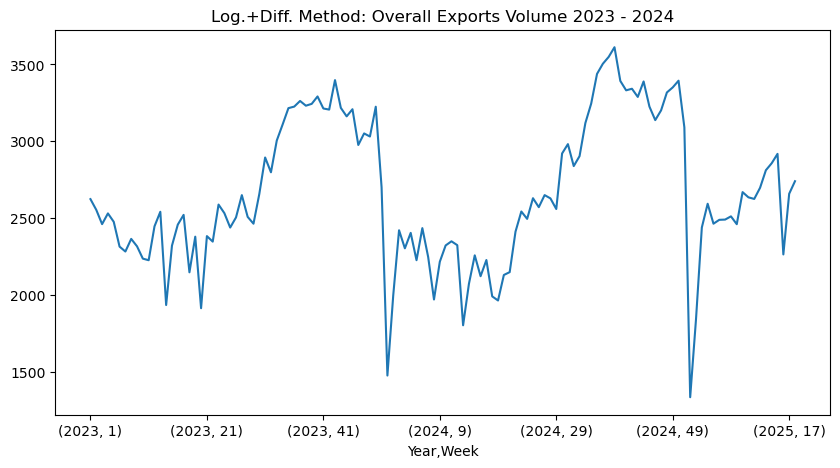

In [13]:
df_box_cox['Volume_box_cox'].plot(kind='line', figsize=(10,5))
plt.title('Log.+Diff. Method: Overall Exports Volume 2023 - 2024')
plt.show()

Conclusión: Sigue siendo igual, porque la serie de tiempo no presenta una naturaleza multiplicativa. 